<a href="https://colab.research.google.com/github/shashankag14/OpenPCDet/blob/DA-15-class-balance-imp/tb_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook fetches the TB logs from Tensorboard-Dev and recreates the plots with further smoothening.
##### All experiments will be present here - https://tensorboard.dev/experiments/
##### Current working experiment ID is v30C9kKURrWVIme8UrhMJw, based on consistency_bs4_split_1_1_trial1_6b3825d

In [58]:

from packaging import version
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d 
import warnings
warnings.filterwarnings('ignore')

Fetch the values of the TB logs for a particular experiment using its experiment ID in tensorboard dev.

In [59]:
experiment_id = "v30C9kKURrWVIme8UrhMJw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

Save the TB log values into excel (added this for any future purpose)

In [60]:
dfw = experiment.get_scalars(pivot=False) 
root_dir = os.getcwd()
csv_path = root_dir + '/tb_experiment.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

Fetch score_fgs of each class and apply 1D gaussian smoothening
TODO : Check approrpiate sigma for smoothening

In [61]:
dfw_score_fgs_car = dfw[dfw.run.str.contains("test/score_fgs/Car")]
dfw_score_fgs_car["smooth_value"] = gaussian_filter1d(dfw_score_fgs_car["value"], sigma=50)

dfw_score_fgs_ped = dfw[dfw.run.str.contains("test/score_fgs/Ped")]
dfw_score_fgs_ped["smooth_value"] = gaussian_filter1d(dfw_score_fgs_ped["value"], sigma=50)

dfw_score_fgs_cyc = dfw[dfw.run.str.contains("test/score_fgs/Cyclist")]
dfw_score_fgs_cyc["smooth_value"] = gaussian_filter1d(dfw_score_fgs_cyc["value"], sigma=50)

# since the number of iterations for which the score_fgs would be present for each class might not be equal, 
# we are interpolating all of them as per the max number of iterations 
max_intervals = max(len(dfw_score_fgs_car), len(dfw_score_fgs_ped), len(dfw_score_fgs_cyc))

# creating dataframe for interpolated smoothened scores
df_ip = pd.DataFrame()
df_ip["itr"] = np.arange(0, max_intervals, 1)
df_ip["ip_score_fgs_car"] = np.interp(df_ip["itr"], dfw_score_fgs_car["step"], dfw_score_fgs_car["smooth_value"])
df_ip["ip_score_fgs_ped"] = np.interp(df_ip["itr"], dfw_score_fgs_ped["step"], dfw_score_fgs_ped["smooth_value"])
df_ip["ip_score_fgs_cyc"] = np.interp(df_ip["itr"], dfw_score_fgs_cyc["step"], dfw_score_fgs_cyc["smooth_value"])

# Save pseudo train score fgs into an excel. This excel can be used in the model to choose the thresholds
root_dir = os.getcwd()
csv_path = root_dir + '/tb_pseudo_train_score_fgs.csv'
df_ip.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, df_ip)
df_ip

,itr,ip_score_fgs_car,ip_score_fgs_ped,ip_score_fgs_cyc
0,0,0.969178,0.807865,0.842554
1,1,0.969178,0.807865,0.842554
2,2,0.969178,0.807865,0.842554
3,3,0.969178,0.807865,0.842554
4,4,0.969178,0.807865,0.842554
...,...,...,...,...
699,699,0.928673,0.701227,0.708161
700,700,0.928583,0.700996,0.707932
701,701,0.928492,0.700765,0.707703
702,702,0.928402,0.700533,0.707474


Plots
1. Car

Text(0.5, 1.0, 'Test score_fgs/Car')

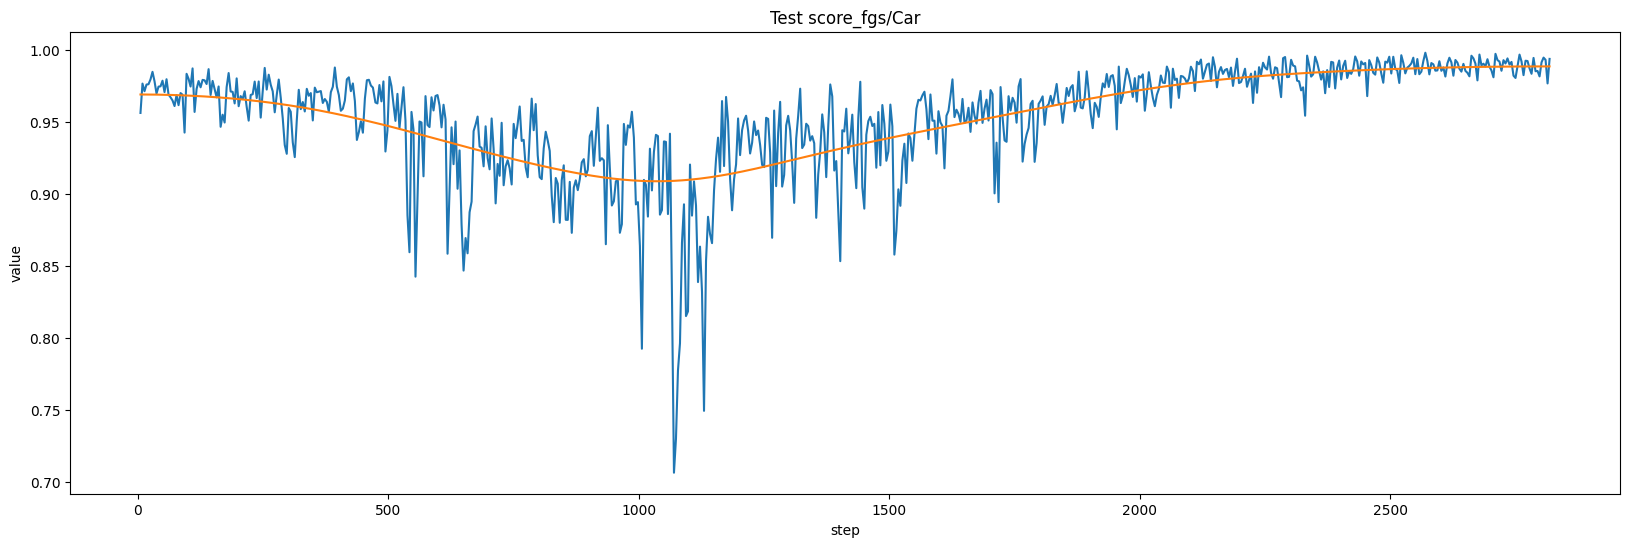

In [62]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=dfw_score_fgs_car, x="step", y="value",
             )
sns.lineplot(data=dfw_score_fgs_car, x="step", y="smooth_value",
             )
plt.title("Test score_fgs/Car")

2. Pedestrian

Text(0.5, 1.0, 'Test score_fgs/Ped')

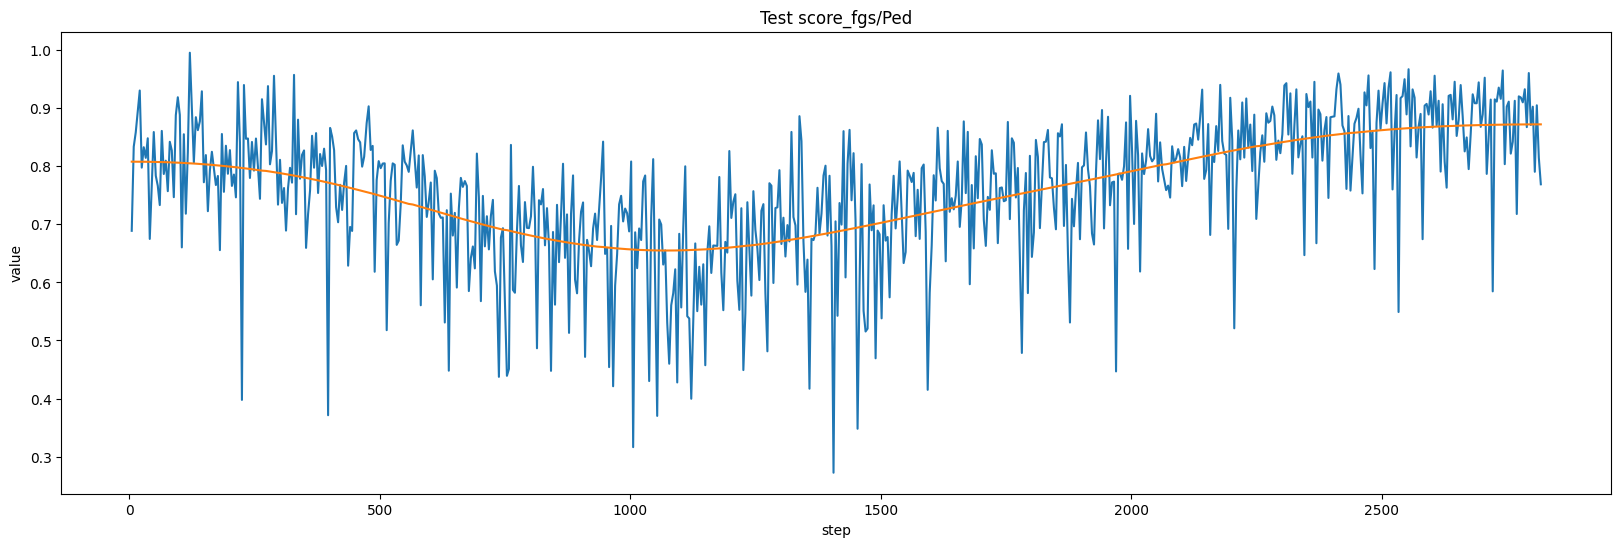

In [63]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=dfw_score_fgs_ped, x="step", y="value",
             )
sns.lineplot(data=dfw_score_fgs_ped, x="step", y="smooth_value",
             )
plt.title("Test score_fgs/Ped")

3. Cyclist

Text(0.5, 1.0, 'Test score_fgs/Cyc')

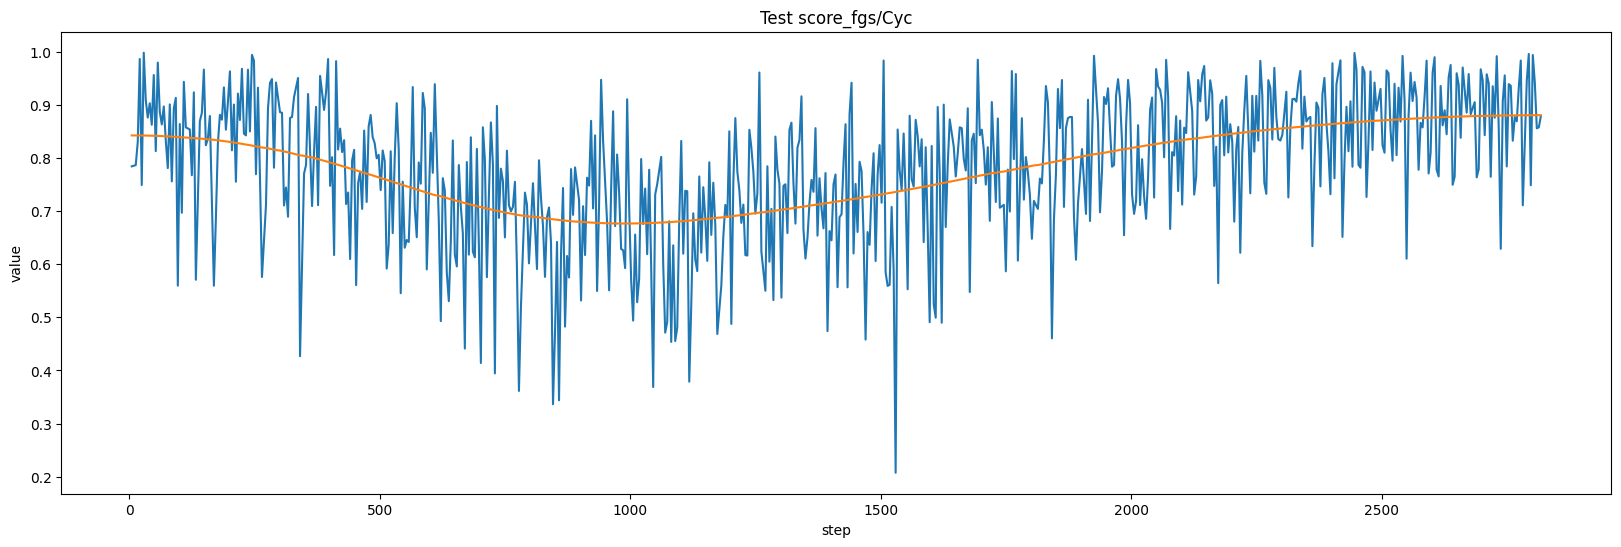

In [64]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=dfw_score_fgs_cyc, x="step", y="value",
             )
sns.lineplot(data=dfw_score_fgs_cyc, x="step", y="smooth_value",
             )
plt.title("Test score_fgs/Cyc")